# Step 3: Visualization for Low-Rate DDoS Traffic

This notebook focuses on visualizing and analyzing Low-Rate DDoS traffic. We target a specific attack type (e.g., **DDoS-SlowLoris**) by creating a binary indicator. In this step, we:

- Compute a correlation heatmap for selected candidate features with the binary target.
- Use a tree-based feature importance method (Random Forest) to identify the most significant features for Low-Rate DDoS detection.

Make sure that you have run Step 1 to produce a preprocessed dataset (e.g., saved as `preprocessed_CICIoT2023.csv`).

## 1. Import Required Libraries

We will use **pandas** and **numpy** for data manipulation, **seaborn** and **matplotlib** for visualization, and **scikit-learn** for the feature importance analysis.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Ensure plots appear inline
%matplotlib inline

## 2. Load the Preprocessed Dataset

Load the cleaned and combined dataset. This notebook assumes the dataset is saved as `preprocessed_CICIoT2023.csv` in the current directory. If you have not saved the preprocessed file from Step 1, please run that step first.

In [2]:
try:
    data = pd.read_csv("preprocessed_CICIoT2023.csv")
    print("Dataset loaded successfully. Shape:", data.shape)
except Exception as e:
    print("Error loading dataset. Please ensure that preprocessed_CICIoT2023.csv exists.")
    raise e

Dataset loaded successfully. Shape: (2366956, 47)


## 3. Create Binary Target Column for Low-Rate DDoS Traffic

We assume that the target label for Low-Rate DDoS traffic is **DDoS-SlowLoris**. A new column `is_low_rate` is created which is 1 if the `label` equals "DDoS-SlowLoris" and 0 otherwise. Adjust the `target_label` variable if you need to target a different attack type.

In [3]:
# Define the target label for low-rate DDoS traffic
target_label = "DDoS-SlowLoris"

# Create a binary column: 1 if the sample is the target low-rate DDoS attack, else 0
data["is_low_rate"] = (data["label"] == target_label).astype(int)
print("Unique values in 'is_low_rate':", data["is_low_rate"].unique())

# Count and print the number of low-rate and non-low-rate samples
low_rate_count = data["is_low_rate"].sum()
non_low_rate_count = len(data) - low_rate_count

print(f"Low-rate samples (is_low_rate=1): {low_rate_count}")
print(f"Non-low-rate samples (is_low_rate=0): {non_low_rate_count}")

Unique values in 'is_low_rate': [0 1]
Low-rate samples (is_low_rate=1): 1176
Non-low-rate samples (is_low_rate=0): 2365780


## 4. Select Candidate Features

Based on the dataset’s features and previous recommendations for Low-Rate DDoS analysis, we select the following candidate numerical features:

- **flow_duration**: Indicator of the duration of the flow.
- **Rate**, **Srate**, **Drate**: Traffic rate features.
- **syn_flag_number**, **ack_flag_number**: Flags that may indicate connection initiation and acknowledgment patterns.
- **IAT**: Inter-arrival time between packets.
- **Number**: Number of packets (or flows) in the sample.
- **Magnitue**, **Radius**, **Variance**, **Weight**: Statistical features that might capture subtle low-rate behaviors.

Feel free to adjust the candidate list as needed.

In [23]:
candidate_features = [
    "flow_duration",
    "Rate",
    "Srate",
    "Drate",
    "syn_flag_number",
    "ack_flag_number",
    "IAT",
    "Number",
    "Magnitue",
    "Radius",
    "Variance",
    "Weight"
]

# Check if the candidate features exist in the dataset
missing_features = [feat for feat in candidate_features if feat not in data.columns]
if missing_features:
    print("Warning: The following candidate features are missing from the dataset:", missing_features)
else:
    print("All candidate features are present.")

All candidate features are present.


## 5. Correlation Heatmap Analysis

We calculate the Pearson correlation matrix among the candidate features and the binary target (`is_low_rate`). This heatmap provides an initial visualization of the relationships between each feature and the target attack type.

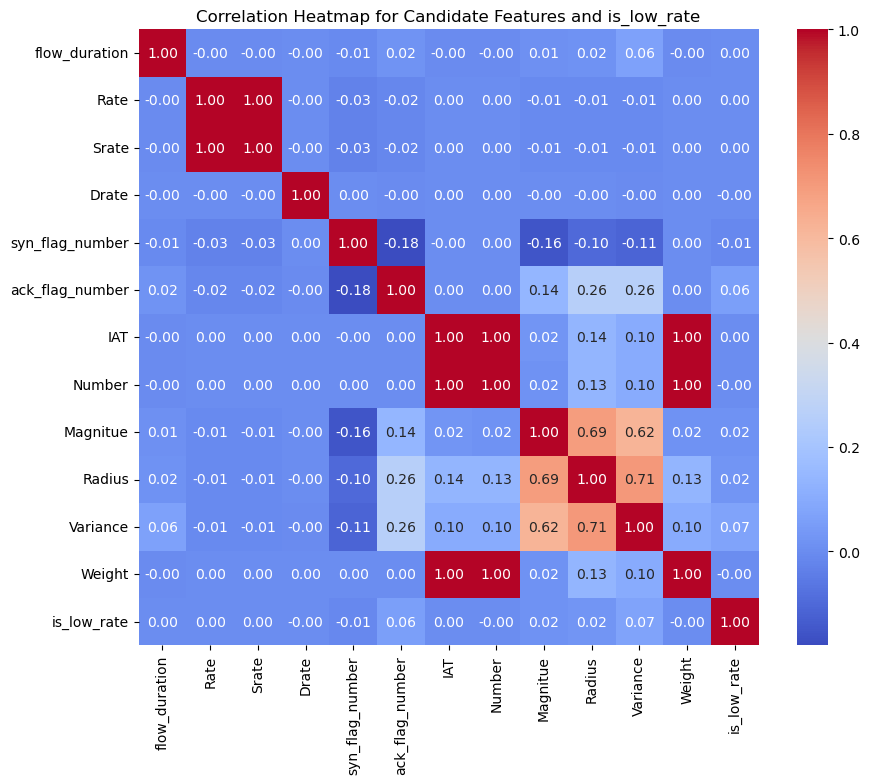

In [31]:
# Create a DataFrame for correlation analysis: candidate features + binary target
corr_features = candidate_features + ["is_low_rate"]
corr_df = data[corr_features].corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap for Candidate Features and is_low_rate")
plt.show()

## 6. Tree-based Feature Importance using Random Forest

We now use a Random Forest classifier to compute feature importances. This method is often robust for identifying key features in a classification task. For efficiency, we sample the dataset if it is very large.

Tree-based Feature Importance:


,Feature,Importance
1,Rate,1.610825e-01
2,Srate,1.591389e-01
0,flow_duration,1.498129e-01
6,IAT,1.201292e-01
9,Radius,1.173441e-01
8,Magnitue,1.131034e-01
10,Variance,8.157865e-02
7,Number,3.817483e-02
11,Weight,3.361181e-02
5,ack_flag_number,2.602367e-02


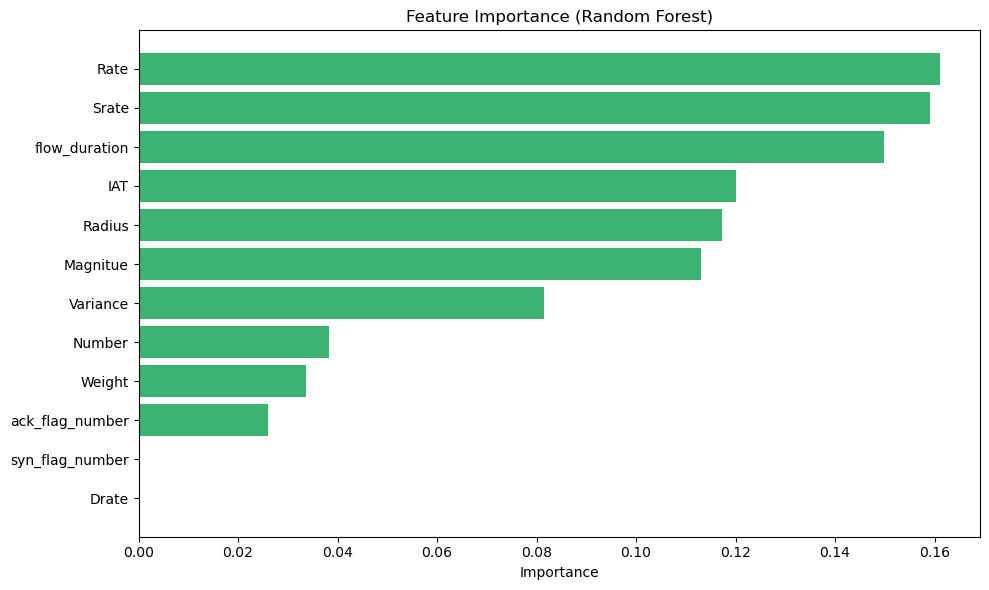

In [29]:
# If the dataset is large, sample a subset for faster computation
if len(data) > 10000:
    data_sample = data.sample(n=10000, random_state=42)
else:
    data_sample = data.copy()

# Separate features and target
X = data_sample[candidate_features]
y = data_sample["is_low_rate"]

# Initialize and train the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    "Feature": candidate_features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("Tree-based Feature Importance:")
display(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="mediumseagreen")
plt.xlabel("Importance")
plt.title("Feature Importance (Random Forest)")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

## 7. Conclusion

In this notebook, we have visualized key aspects of Low-Rate DDoS traffic by:

- Creating a binary indicator for the target attack type (e.g., DDoS-SlowLoris).
- Generating a correlation heatmap for candidate features and the target variable.
- Using a Random Forest classifier to estimate the importance of each feature.

These visualizations serve as a basis for further analysis and feature selection (e.g., using Boruta or LASSO) to improve detection models for Low-Rate DDoS attacks.